In [1]:
import os
os.chdir('/home/berling/reduce_opto_response/')
import numpy as np

# global variabl setup
neuron_model_name = "L23_PC_cADpyr229_1"
adex_fit = '../snake_workflow/adex_models/fit_to_L23_PC_cADpyr229_1.nestml'
ChR_soma_density=13e9
ChR_distribution='uniform'
stimulator_dict = dict(
        diameter_um=50,
        NA=0.1)
temp_protocol=dict(
    duration_ms=200,
    delay_ms=1,
    total_rec_time_ms=300,
    interpol_dt_ms=1
)
interpol_dt_ms = temp_protocol['interpol_dt_ms']

stim_intensity_mWPERmm2 = 0.09

driving_conductance_nS = np.load('RON_cond_reduced_calculation.npy')
driving_times_ms = np.arange(0, len(driving_conductance_nS))

In [2]:
# Run full simulation
from neurostim.analysis import quick_sim_setup
from neurostim.cell import Cell
from neurostim import models
import numpy as np
import pandas as pd
from neuron import h
from scipy.signal import find_peaks

simcontrol = quick_sim_setup(
    cell_dict = dict(
        cellmodel=neuron_model_name,
        ChR_soma_density=ChR_soma_density,
        ChR_distribution=ChR_distribution),
    stimulator_dict = stimulator_dict
)

# Define recording variables
rec_vars = [[],[]]
# append time and soma voltage recoding
rec_vars[0].append('time [ms]')
rec_vars[1].append(h._ref_t)
rec_vars[0].append('v_soma_mV')
rec_vars[1].append(simcontrol.cell.model.soma_sec(0.5)._ref_v)

tmp = simcontrol.run(
    temp_protocol=temp_protocol,
    stim_location=(0, 0, 0),
    stim_intensity_mWPERmm2=stim_intensity_mWPERmm2,
    rec_vars=rec_vars,
    interpol_dt_ms=interpol_dt_ms
)
# measure APC
v_soma = tmp[['time [ms]', 'v_soma_mV']]
v_soma_until_stim_period_stops = v_soma.loc[v_soma['time [ms]']<=temp_protocol['duration_ms']+temp_protocol['delay_ms']]
x = tmp['time [ms]']
y = tmp['v_soma_mV']
peaks, properties = find_peaks(y, height=-20, prominence=10)
spike_times = x[peaks]
np.save('spike_times_full.npy', spike_times)

--No graphics will be displayed.



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Jan  9 2025 17:16:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Ca_HVA: gbar_Ca_HVA_somatic = 374.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_axonal = 306.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_basal = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_apical = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_somatic = 778.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_axonal = 50.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_basal = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_apical = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ih: gbar_Ih_somatic = 80.0 uS/cm^2, e_Ih = 

In [2]:
# Run somatic-equivalent conductance at soma of HH-model
from neurostim.analysis import quick_sim_setup
from neurostim.cell import Cell
from neurostim import models
import numpy as np
import pandas as pd
from neuron import h
from scipy.signal import find_peaks

time_ms = driving_times_ms
# set up neuron model
cellmodel = getattr(models, neuron_model_name)
cell = Cell(
    model=cellmodel(),
    ChR_soma_density=13e9,
    ChR_distribution='uniform'
)
# insert new conductance to 'inject' conductance
soma = cell.sections[0]
soma.insert('g_chanrhod')

# define/load driving stimulus
conductance_nS = driving_conductance_nS

# driving stimulus
t = h.Vector(time_ms)
y = h.Vector(conductance_nS*(100/soma(0.5).area())) # needs to be rescaled as gcat is density mechanism

# Define recording variables
rec_vars = [[],[]]
rec_time = h.Vector().record(h._ref_t)
rec_v = h.Vector().record(soma(0.5)._ref_v)

# run simulation with injected conductance
h.load_file('stdrun.hoc')

# play the stimulus into soma(0.5)'s ina
# the last True means to interpolate; it's not the default, but unless
# you know what you're doing, you probably want to pass True there
y.play(soma(0.5)._ref_gcat2_g_chanrhod, t, True)

# h.v_init, h.tstop= -70, temp_protocol['total_rec_time_ms']
h.v_init, h.tstop= -70, 201
h.run()

# measure APC
x = np.array(rec_time)
y = np.array(rec_v)
peaks, properties = find_peaks(y, height=-20, prominence=10)
spike_times = x[peaks]
np.save('spike_times_RON_full.npy', spike_times)

--No graphics will be displayed.



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Jan  9 2025 17:16:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Ca_HVA: gbar_Ca_HVA_somatic = 374.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_axonal = 306.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_basal = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_apical = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_somatic = 778.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_axonal = 50.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_basal = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_apical = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ih: gbar_Ih_somatic = 80.0 uS/cm^2, e_Ih = 

In [ ]:
# see python file: run_RON_adex_spike_profile.py

In [3]:
st_HH_full      = np.load('spike_times_full.npy')
st_HH_reduced   = np.load('spike_times_RON_full.npy')
st_AdEx_reduced = np.load('spike_times_RON_adex.npy')

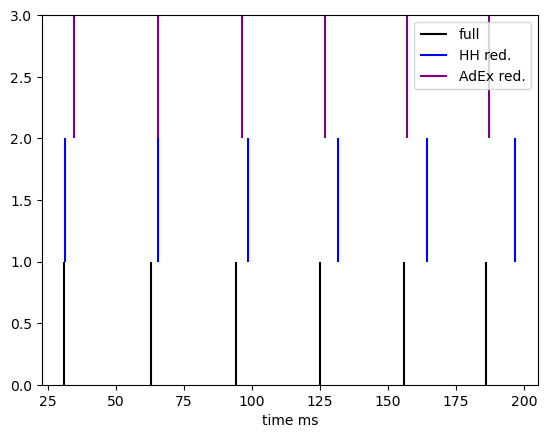

In [4]:
import matplotlib.pyplot as plt
plt.vlines(st_HH_full, ymin=0, ymax=1, label='full', color='black') 
plt.vlines(st_HH_reduced, ymin=1, ymax=2, label='HH red.', color='blue')
plt.vlines(st_AdEx_reduced, ymin=2, ymax=3, label='AdEx red.', color='purple')
plt.ylim(-0., 3.)
plt.xlabel('time ms')
plt.legend()

In [5]:
st_HH_full

array([], dtype=float64)